In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
# configuration
DATA_DIR = r"C:\Users\dell\Desktop\Cricket Shot Classifier\data"
BATCH_SIZE = 32
NUM_EPOCHS = 15
LR = 1e-4
NUM_CLASSES = 4
UNFREEZE_EPOCH = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_SAVE_DIR = "checkpoints"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

In [3]:
# Data transforms with no augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [4]:
# Full dataset
full_data = datasets.ImageFolder(DATA_DIR, transform=transform)
targets = [label for _, label in full_data.samples]

# Stratified Split (85% train, 15% val)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
train_idx, val_idx = next(splitter.split(np.zeros(len(targets)), targets))

train_dataset = Subset(full_data, train_idx)
val_dataset = Subset(full_data, val_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


In [6]:
# Model: ResNet50
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, NUM_CLASSES)
)
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=LR)


In [8]:
def evaluate_model():
    model.eval()
    correct, total = 0, 0
    total_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_loss = total_loss / total
    val_acc = correct / total
    return val_loss, val_acc


In [9]:
def train_model():
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(NUM_EPOCHS):
        if epoch == UNFREEZE_EPOCH:
            for name, param in model.named_parameters():
                if "layer4" in name or "fc" in name:
                    param.requires_grad = True
            global optimizer
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR / 10)
            print("🔓 Unfroze layer4 and fc for fine-tuning.")

        model.train()
        running_loss, correct = 0.0, 0

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{NUM_EPOCHS}]", leave=False)
        for images, labels in loop:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)
        val_loss, val_acc = evaluate_model()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Save model for each epoch
        torch.save(model.state_dict(), os.path.join(MODEL_SAVE_DIR, f"epoch_{epoch+1}.pth"))

    # Plot stats
    plot_training_stats(history)
    generate_report()


In [10]:
def plot_training_stats(history):
    epochs = range(1, NUM_EPOCHS + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.savefig("training_stats.png")
    print("📈 Training plots saved to training_stats.png")

In [11]:
def generate_report():
    # Load best or last model
    latest_model = os.path.join(MODEL_SAVE_DIR, f"epoch_{NUM_EPOCHS}.pth")
    model.load_state_dict(torch.load(latest_model))
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=full_data.classes))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_data.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix.png")
    print("📊 Confusion matrix saved to confusion_matrix.png")

[Epoch 1] Train Loss: 1.1258 | Train Acc: 0.5651 | Val Loss: 0.8698 | Val Acc: 0.7179


[Epoch 2] Train Loss: 0.7709 | Train Acc: 0.7440 | Val Loss: 0.7001 | Val Acc: 0.7532


[Epoch 3] Train Loss: 0.6134 | Train Acc: 0.8005 | Val Loss: 0.4905 | Val Acc: 0.8731


[Epoch 4] Train Loss: 0.5131 | Train Acc: 0.8356 | Val Loss: 0.4498 | Val Acc: 0.8702


[Epoch 5] Train Loss: 0.4611 | Train Acc: 0.8543 | Val Loss: 0.3705 | Val Acc: 0.9055
🔓 Unfroze layer4 and fc for fine-tuning.


[Epoch 6] Train Loss: 0.2673 | Train Acc: 0.9258 | Val Loss: 0.1230 | Val Acc: 0.9704


[Epoch 7] Train Loss: 0.0910 | Train Acc: 0.9833 | Val Loss: 0.0797 | Val Acc: 0.9760


[Epoch 8] Train Loss: 0.0408 | Train Acc: 0.9945 | Val Loss: 0.0613 | Val Acc: 0.9788


[Epoch 9] Train Loss: 0.0222 | Train Acc: 0.9985 | Val Loss: 0.0471 | Val Acc: 0.9845


[Epoch 10] Train Loss: 0.0131 | Train Acc: 0.9995 | Val Loss: 0.0441 | Val Acc: 0.9873


[Epoch 11] Train Loss: 0.0102 | Train Acc: 0.9993 | Val Loss: 0.0403 | Val Acc: 0.9859


[Epoch 12] Train Loss: 0.0078 | Train Acc: 0.9998 | Val Loss: 0.0364 | Val Acc: 0.9887


[Epoch 13] Train Loss: 0.0058 | Train Acc: 0.9998 | Val Loss: 0.0365 | Val Acc: 0.9901


[Epoch 14] Train Loss: 0.0053 | Train Acc: 0.9995 | Val Loss: 0.0367 | Val Acc: 0.9859


[Epoch 15] Train Loss: 0.0033 | Train Acc: 1.0000 | Val Loss: 0.0325 | Val Acc: 0.9887
📈 Training plots saved to training_stats.png

📊 Classification Report:
                 precision    recall  f1-score   support

          drive       0.98      0.99      0.98       184
legglance-flick       1.00      0.99      0.99       168
       pullshot       0.98      0.99      0.99       189
          sweep       0.99      0.99      0.99       168

       accuracy                           0.99       709
      macro avg       0.99      0.99      0.99       709
   weighted avg       0.99      0.99      0.99       709

📊 Confusion matrix saved to confusion_matrix.png


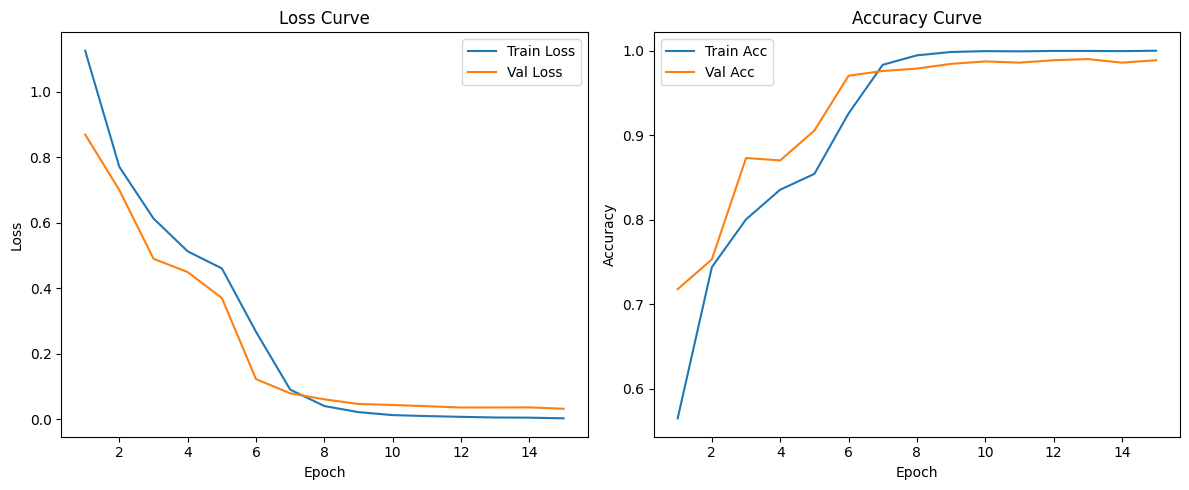

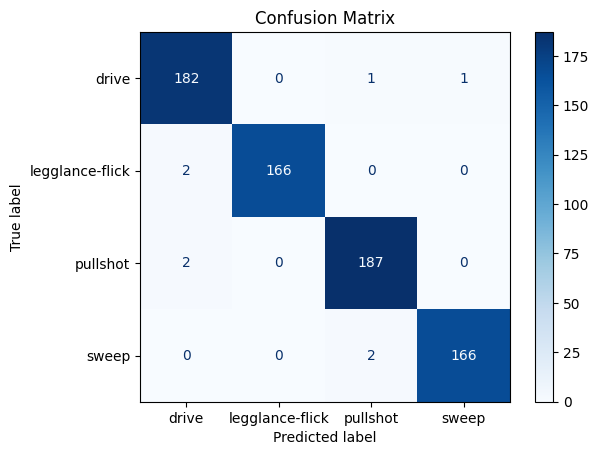

In [12]:
train_model()

In [17]:
def grad_cam_visualization(image_path, save_path="gradcam_output.jpg"):
    import cv2
    import numpy as np
    from PIL import Image
    from torchvision import transforms

    model.load_state_dict(torch.load("checkpoints/epoch_15.pth"))
    model.eval()

    # Preprocessing
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    img = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(img).unsqueeze(0).to(DEVICE)

    # Hook containers
    activations = []
    gradients = []

    # Forward hook
    def forward_hook(module, input, output):
        activations.append(output)

    # Backward hook (use full backward hook for compatibility)
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # Attach hooks to last conv layer
    target_layer = model.layer4[-1].conv3  # last conv layer in ResNet50
    fwd_handle = target_layer.register_forward_hook(forward_hook)
    bwd_handle = target_layer.register_full_backward_hook(backward_hook)

    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()

    # Backward pass
    model.zero_grad()
    class_score = output[0, pred_class]
    class_score.backward()

    # Remove hooks
    fwd_handle.remove()
    bwd_handle.remove()

    if not activations or not gradients:
        raise RuntimeError("❌ Grad-CAM hooks failed to capture data.")

    # Process activations and gradients
    activation = activations[0].squeeze()
    gradient = gradients[0].squeeze()

    weights = torch.mean(gradient, dim=(1, 2))
    cam = torch.zeros(activation.shape[1:], dtype=torch.float32).to(DEVICE)

    for i, w in enumerate(weights):
        cam += w * activation[i]

    cam = cam.cpu().detach().numpy()
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()

    heatmap = cv2.resize(cam, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    original_img = np.array(img.resize((224, 224)))
    if original_img.dtype != np.uint8:
        original_img = (original_img * 255).astype(np.uint8)

    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)
    cv2.imwrite(save_path, superimposed_img)
    print(f"✅ Grad-CAM saved to: {save_path}")


In [18]:
def predict_image(image_path):
    import torch
    from torchvision import transforms, datasets, models
    from PIL import Image
    import torch.nn.functional as F
    import numpy as np

    # Preprocessing
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Load image
    image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0).to(DEVICE)

    # Load class names
    dataset = datasets.ImageFolder(DATA_DIR)
    class_names = dataset.classes

    # Load model
    model = models.resnet50()
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, len(class_names))
    )
    model.load_state_dict(torch.load("checkpoints/epoch_15.pth", map_location=DEVICE))
    model.to(DEVICE)
    model.eval()

    # Inference
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1).cpu().numpy()[0]

    # Get top-1 probability
    max_prob = np.max(probabilities)
    predicted_indices = [i for i, p in enumerate(probabilities) if (max_prob - p) <= 0.05]

    # Preserve original order of classes
    predicted_class = [class_names[i] for i in predicted_indices]

    # Map to label:probability
    result = {class_names[i]: round(probabilities[i] * 100, 2) for i in range(len(class_names))}

    return predicted_class, result


In [20]:
import cv2

Predicted Class(es): ['sweep']
Prediction Results:
drive: 0.01%
legglance-flick: 7.31%
pullshot: 0.01%
sweep: 92.68%
✅ Grad-CAM saved to: gradcam_output.jpg


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

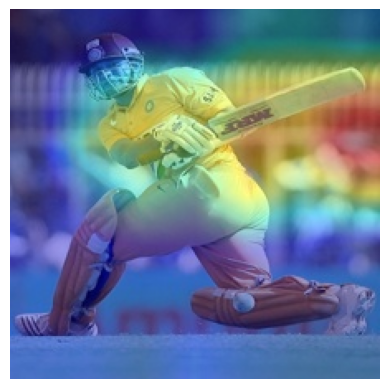

In [21]:
img = r"C:\Users\dell\Desktop\Cricket Shot Classifier\Test\sweep1.webp"
predicted_class, result = predict_image(img)

print(f"Predicted Class(es): {predicted_class}")
print("Prediction Results:")
for cls in sorted(result.keys()):
    print(f"{cls}: {result[cls]:.2f}%")


grad_cam_visualization(img)
plt.imshow(cv2.cvtColor(cv2.imread("gradcam_output.jpg"), cv2.COLOR_BGR2RGB))
plt.axis('off')